In [2]:
import numpy as np
import pandas as pd
from simplicialX import *
import networkx as nx

import chess
import chess.pgn

In [69]:
# строим комплекс для текущей позиции в партии, для текущего цвета
def get_complex(current_game, current_color):
    
    white = True
    black = False
    
    if current_color == 'white':
        color = white
    else:
        color = black
        
    board = current_game.board()

    c = SimplicialComplex()
    for i in range(6):
       c.add([i])

    R = np.zeros([64,6], dtype=int)
    for i in range(64):
      for attacker in board.attackers(color, i):
        R[i, board.piece_type_at(attacker)-1] = 1

    for i in range(64):
      new_simplex = []
      for j in range(6):
        if R[i].tolist()[j] == 1:
          new_simplex.append(j)
      if new_simplex != []:
        c.add(new_simplex)
      
    return c

# строим набор комплексов для каждой позиции в партии
def create_complex_data(current_game, current_color):
    data = list()
    moves = 0
    mean_legal_moves = 0
    while True:
        data.append(get_complex(current_game, current_color))
        if moves > 15:
            mean_legal_moves += current_game.board().legal_moves.count()
        if current_game.next() is None:
            break
        current_game = current_game.next()
        
        moves += 1
    if mean_legal_moves == 0:
        return (data, moves, mean_legal_moves)
    else:
        return (data, moves, mean_legal_moves / (moves - 15))

# строим признаки комплекса только для одного цвета
def create_features(current_game, current_color):
    data, move = create_complex_data(current_game, current_color)
    features = np.zeros((move + 1, 12))
    i = 0
    for c in data:
        features[i] = np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal()))
        i += 1
    f = np.mean(features, axis=0)
    f = np.append(f, [move])
    return f

# строим признаки обоих комплексов и для белых и для чёрных
def create_features_both(current_game):
    data1, move, mlm = create_complex_data(current_game, 'white')
    data2, move, mlm = create_complex_data(current_game, 'black')
    features = np.zeros((move + 1, 12))
    features_2 = np.zeros((move + 1, 24))
    
    i = 0
    coef = 1 / len(features)
    
    for c in data1:
        if i <= 15:
            features[i] = coef * np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal()))
        else:
            features[i] = np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal()))
        i += 1
     
    i = 0

    for c in data2:
        if i <= 15:
            features_2[i] = np.append(features[i], coef * np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal())))
        else:
            features_2[i] = np.append(features[i], np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal())))
        i += 1
    
    f = np.mean(features_2, axis=0)
    f = np.append(f, [move, mlm])
    return f

def create_data_features(name):
    pgn = open(name + '.pgn')
    df = pd.DataFrame(index=np.arange(0), columns=np.arange(25))
    j = 0
    while True:
        current_game = chess.pgn.read_game(pgn)
        
        if current_game is None:
            break
        
        #current_color = 'black'
        #headers = current_game.headers
        #if name in headers.get("White", "?"):
            #current_color = 'white'
        cur_f = create_features_both(current_game)
        df = pd.concat([df, pd.DataFrame(cur_f).T])
    return df
        

In [50]:
#Df_1 = pd.read_csv('OldGames_2.csv')
#D2f_1 = pd.read_csv('NewGames_2.csv')

kas_df = pd.read_csv('Kasparov.csv')
car_df = pd.read_csv('Carlsen.csv')


In [51]:
kas_df['Name'] = 'Kasparov'
car_df['Name'] = 'Carlsen'
#Df_1['Time'] = 'Old'
#D2f_1['Time'] = 'New'

In [52]:
data = pd.concat([kas_df, car_df])
#data = pd.concat([Df_1, D2f_1])
data = data.drop(['Unnamed: 0'], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,Name
0,2.759036,3.204819,3.409639,3.108434,4.132530,3.240964,1.734940,1.710843,1.891566,2.168675,2.698795,2.072289,82.0,Kasparov
1,1.842105,2.184211,1.500000,2.000000,1.105263,1.736842,1.315789,1.276316,0.828947,1.381579,0.710526,1.092105,75.0,Kasparov
2,3.147059,3.382353,3.882353,3.058824,4.470588,3.588235,2.441176,1.941176,2.294118,2.735294,3.147059,2.117647,33.0,Kasparov
3,2.980392,4.372549,3.274510,3.117647,4.490196,3.333333,2.196078,2.882353,2.058824,2.392157,2.980392,2.019608,50.0,Kasparov
4,2.214286,4.071429,3.476190,3.845238,3.488095,3.452381,1.904762,2.333333,1.738095,2.440476,1.880952,1.690476,83.0,Kasparov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2.470588,1.926471,3.691176,3.117647,2.279412,2.514706,1.602941,1.191176,2.264706,2.220588,1.470588,1.323529,67.0,Carlsen
1796,1.562500,1.118750,0.543750,1.737500,1.231250,1.681250,1.362500,0.843750,0.312500,1.381250,0.743750,1.150000,159.0,Carlsen
1797,2.431818,3.795455,2.261364,3.500000,3.431818,2.806818,1.795455,2.318182,1.568182,2.306818,2.079545,1.340909,87.0,Carlsen
1798,2.552083,2.677083,3.156250,3.416667,3.468750,2.645833,1.822917,1.781250,1.958333,2.489583,2.416667,1.625000,95.0,Carlsen


In [53]:
X = data.iloc[:,:-1].values
y = data['Name']

0       Kasparov
1       Kasparov
2       Kasparov
3       Kasparov
4       Kasparov
          ...   
1795     Carlsen
1796     Carlsen
1797     Carlsen
1798     Carlsen
1799     Carlsen
Name: Name, Length: 3600, dtype: object

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import GradientBoostingClassifier

In [16]:
from sklearn import model_selection

In [19]:
import matplotlib.pyplot as plt

In [55]:
classifiers = []

classifiers.append(('SGD', SGDClassifier(max_iter = 1200, tol = 1e-4)))
classifiers.append(('SVL', SVC(kernel = 'rbf', gamma=0.05, probability = True)))
classifiers.append(('RF', RandomForestClassifier(n_estimators=44, max_depth=13, random_state=3)))
classifiers.append(('AB', AdaBoostClassifier()))
classifiers.append(('DT', DecisionTreeClassifier()))
classifiers.append(('LR', LogisticRegression(solver = 'lbfgs', max_iter = 500, multi_class = 'auto')))
classifiers.append(('NB', GaussianNB()))
classifiers.append(('SVR', SVC(gamma = 2, C = 1.0)))
classifiers.append(('MLP', MLPClassifier(alpha = 0.01, max_iter = 200, solver = 'lbfgs', tol = 0.001)))
classifiers.append(('KNN', KNeighborsClassifier(3)))
classifiers.append(('QDA', QuadraticDiscriminantAnalysis()))
classifiers.append(('LDA', LinearDiscriminantAnalysis()))

In [56]:
results = []
names = []
for name, classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    results.append(accuracy_score(y_pred, y_test))
    names.append(name)


/home/ilya/chess/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [31]:
import seaborn as sns

In [58]:
crdata = pd.DataFrame(data={'Names': names, 'Score': results})
crdata

,Names,Score
0,SGD,0.509722
1,SVL,0.587500
2,RF,0.581944
3,AB,0.602778
4,DT,0.538889
5,LR,0.598611
6,NB,0.583333
7,SVR,0.540278
8,MLP,0.613889
9,KNN,0.523611


<AxesSubplot:>

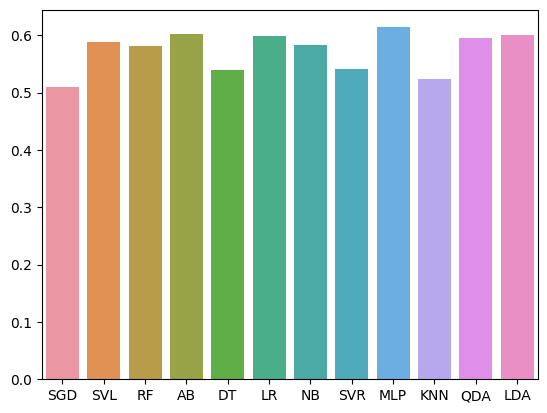

In [59]:
sns.barplot( x=names, y=results)

In [60]:
Df_1 = pd.read_csv('OldGames_2.csv')
D2f_1 = pd.read_csv('NewGames_2.csv')

In [61]:
Df_1['Time'] = 'Old'
D2f_1['Time'] = 'New'

In [62]:
data2 = pd.concat([Df_1, D2f_1])
data2 = data2.drop(['Unnamed: 0'], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Time
0,2.256039,3.001260,2.753413,2.993069,3.609326,1.983407,1.559336,2.532031,2.081075,2.165932,...,1.723167,1.151229,1.634110,2.704474,1.760765,2.474270,1.253938,68.0,40.188679,Old
1,1.600951,0.848914,1.401313,2.184925,1.816885,1.123472,0.951788,0.665346,0.759959,1.460955,...,1.868719,1.247850,0.633545,1.152331,1.833182,1.493436,1.279991,93.0,29.794872,Old
2,1.615207,1.352066,2.348760,2.520000,2.824463,1.891570,1.214545,0.742810,1.592727,1.589421,...,2.056860,1.208595,1.234711,1.574876,1.610579,2.029421,1.609917,54.0,42.102564,Old
3,2.172053,1.725454,1.827947,2.766082,2.477685,1.422284,1.714374,1.384734,1.310865,2.027701,...,1.457064,1.150816,0.927054,1.468452,1.657741,2.222838,1.115112,56.0,34.317073,Old
4,2.951560,1.911271,3.355624,2.994093,3.584594,2.746337,1.929348,1.342391,2.406309,2.036980,...,2.398393,1.667179,1.516068,2.905718,2.427457,2.461011,1.470699,91.0,37.118421,Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,2.115851,2.070582,2.505653,2.122562,2.177830,2.338003,1.699608,1.539255,1.920634,1.497815,...,1.411828,1.383812,0.753389,1.484077,1.268907,1.162695,1.021215,148.0,26.398496,New
1016,1.216263,1.800173,2.705882,2.031142,2.061419,1.138408,0.829585,0.836505,1.741349,1.084775,...,2.171280,1.377163,1.626298,1.676471,1.318339,1.565744,1.143599,33.0,40.000000,New
1017,1.803455,3.468718,2.840615,3.209610,3.745391,2.838438,1.271738,1.946436,1.523153,1.810422,...,2.201771,1.763972,2.561184,2.535346,0.883873,2.402526,1.763391,82.0,31.686567,New
1018,2.628056,2.602778,2.201389,3.108611,1.636111,2.916389,1.560000,1.877500,1.459444,2.273611,...,1.600556,1.259444,1.262778,1.841667,1.974444,1.025556,1.308333,59.0,38.704545,New


In [63]:
X = data2.iloc[:,:-1].values
y = data2['Time']
y

0       Old
1       Old
2       Old
3       Old
4       Old
       ... 
1015    New
1016    New
1017    New
1018    New
1019    New
Name: Time, Length: 2055, dtype: object

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [65]:
results = []
names = []
for name, classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    results.append(accuracy_score(y_pred, y_test))
    names.append(name)

/home/ilya/chess/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [66]:
crdata2 = pd.DataFrame(data={'Names': names, 'Score': results})
crdata2

,Names,Score
0,SGD,0.540146
1,SVL,0.532847
2,RF,0.557178
3,AB,0.518248
4,DT,0.554745
5,LR,0.508516
6,NB,0.552311
7,SVR,0.437956
8,MLP,0.525547
9,KNN,0.554745


<AxesSubplot:>

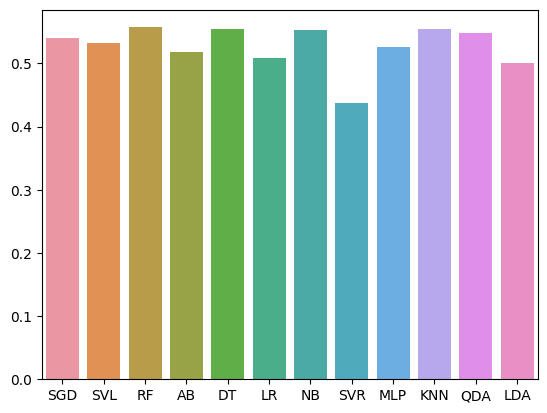

In [67]:
sns.barplot( x=names, y=results)